# BSRC: Summer 2019 Research Project 

## Modifying the Search Function to Work on Databases

While the first function I wrote in the Initial_Stage notebook seemed to work well for a small number of sources, it would be slow and memory heavy for a large number of sources. In order to keep from reading all of the database to find objects within the field of view.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
import mysql.connector

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Querying a database by including functions

In [1]:
def connect_to_db(db = 'loganp'):
    '''
    Connects to the Breakthrough Listen database
        
    Returns:
    --------
    db : MySQLConnection
        MySQLConnection to Breakthrough Listen database
    '''
    db = mysql.connector.connect(
      option_files='/Users/tyler/.my.cnf',
      database = db
    )
    return db

def box_filter(c_ra, c_dec, beam_rad, table):
    '''
    Returns a 
    
    Parameters:
    ----------
    c_ra, c_dec : float
        Pointing coordinates of the telescope in radians
    beam_rad : float
        Angular radius of the primary beam in radians
    table : str
        Table within database where 
    
    Returns:
    -------
    
    
    Reference:
    ---------
    http://janmatuschek.de/LatitudeLongitudeBoundingCoordinate
    
    '''
    if c_dec - beam_rad <= - np.pi / 2.0:
        ra_min, ra_max = 0.0, 2.0 * np.pi
        dec_min = -np.pi / 2.0
        dec_max = c_dec + beam_rad
        
    elif c_dec + beam_rad >= np.pi / 2.0:
        ra_min, ra_max = 0.0, 2.0 * np.pi
        dec_min = c_dec - beam_rad
        dec_max = np.pi / 2.0
    
    else:
        ra_offset = np.arcsin(np.sin(beam_rad) / np.cos(c_dec))
        ra_min  = c_ra - ra_offset
        ra_max  = c_ra + ra_offset
        dec_min = c_dec - beam_rad
        dec_max = c_dec + beam_rad
        
    bounds = np.rad2deg([ra_min, ra_max, dec_min, dec_max])
        
    query = """
            SELECT * 
            FROM {table} 
            WHERE ({ra_min} < ra  AND ra < {ra_max}) AND 
                  ({dec_min} < decl AND decl < {dec_max})\
            """.format(table = table, ra_min = bounds[0], ra_max = bounds[1], 
                       dec_min = bounds[2], dec_max = bounds[3])
    
    return query

def select_targets(c_ra, c_dec, beam_rad, table = '1M_target_list'):
    '''
    
    Returns a string to query the 1 million star database to find sources within some primary beam area
    
    Parameters:
    -----------
    table : str
        Name of the table that is being queried
    c_ra, c_dec : float
        Pointing coordinates of the telescope in radians
    beam_rad: float
        Angular radius of the primary beam in radians    
    
    Returns:
    --------
    tb : DataFrame
        Returns a pandas DataFrame containing the objects meeting the filter criteria
        
    
    
    '''
    
    mask = box_filter(c_ra, c_dec, beam_rad, table)
    
    query = """\
            SELECT * 
            FROM ({mask}) as sub_filter
            WHERE ACOS( SIN(RADIANS(decl)) * SIN({c_dec}) + COS(RADIANS(decl)) * 
            COS({c_dec}) * COS({c_ra} - RADIANS(ra))) < {beam_rad}; \
            """.format(mask = mask, c_ra = c_ra, c_dec = c_dec, beam_rad = beam_rad)

    tb = pd.read_sql(query, con = connect_to_db())
    
    return tb

In [4]:
c_ra = np.deg2rad(15)
c_dec = np.deg2rad(-40)
beam_rad = np.deg2rad(3)

In [5]:
tb = select_targets(c_ra, c_dec, beam_rad)

In [6]:
tb.head()

,Ind,source_id,ref_epoch,ra,ra_error,decl,dec_error,parallax,parallax_error,parallax_over_error,...,lum_percentile_upper,lum_percentile_lower,dist_c,fwhm_lo_c,fwhm_hi_c,sd_c,teff_val_c,sptype_c,Project,Name
0,576021,4989399774745144448,2015.5,15.7207,0.092435,-37.6277,0.052120,87.8684,0.116319,755.406,...,0.0,0.0,11.3807,11.3630,11.3985,0.015065,0.0,M3.5V,Volume Complete,Volume Complete
1,578012,4989114210959175808,2015.5,16.1204,0.042209,-38.4644,0.027820,44.0027,0.054959,800.647,...,0.0,0.0,22.7259,22.6926,22.7594,0.028383,0.0,M1V,Volume Complete,Volume Complete
2,579504,4987578158855872384,2015.5,13.5483,0.040123,-39.6782,0.023367,37.2969,0.055459,672.517,...,0.0,0.0,26.8120,26.7651,26.8590,0.039865,0.0,F7V,Volume Complete,Volume Complete
3,580918,4999214840166796416,2015.5,11.5702,0.026140,-40.2979,0.028010,33.5035,0.044986,744.759,...,0.0,0.0,29.8478,29.8006,29.8950,0.040074,0.0,M1.5V,Volume Complete,Volume Complete
4,581109,4986885500889922176,2015.5,13.3496,0.032689,-41.2394,0.021742,33.1309,0.046654,710.138,...,0.0,0.0,30.1834,30.1334,30.2335,0.042501,0.0,M0V,Volume Complete,Volume Complete


## Test the Function

Here I'll test the SQL search function I wrote to search for sources inside some field of view. The astropy separation function will be used to determine the distance between the center pointing and the sources. All sources should be within three degrees of the pointing center.

In [7]:
pointing = SkyCoord(np.rad2deg(c_ra), np.rad2deg(c_dec), unit=(u.deg))
sources = SkyCoord(tb['ra'], tb['decl'], unit=(u.deg))
dist = pointing.separation(sources).degree

Now, I'll sort the angular distances and print the 10 largest angular distances to see if they fall within the three degree cut.

In [8]:
np.sort(dist)[::-1][:10]

array([2.99905653, 2.99850549, 2.99509336, 2.99128085, 2.98863672,
       2.98622088, 2.98539246, 2.98420895, 2.982386  , 2.98164478])

I'll also plot a histogram of the number of sources by angular distance. Bins with larger angular distances should have more sources than bins with smaller angular distances.

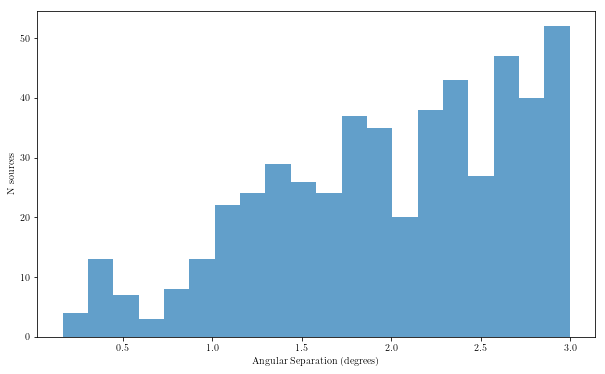

In [13]:
plt.figure(figsize=(10,6))
plt.hist(dist, bins=20, alpha=0.7)
plt.xlabel('Angular Separation (degrees)')
plt.ylabel('N sources')
#plt.show()
plt.savefig('distribution_of_targets.png', dpi=100)